If you want to run the experiments, change this parameter to the amount of samples you want to use.


In [1]:
N_SAMPLES: int | None = 100  # value <= 7500; None defaults to 7500

todo: 
- mettere che usiamo 1 step di learning per tpt e 1 per tnt, come da paper
- gli iperparametri son oquelli dei paper, for fairness.

# 1. Introduction

In this project, we focus on **Test-Time Adaptation (TTA)**, which has recently gained traction due to its ability to enhance model performance without requiring access to training data.

In this project, we focus on **TTA for image classification**, particularly using **CLIP** [[2](#ref-clip2021)] with **TPT** [[3](#ref-tpt2022)]. Our approach involves adapting the model on **single-image test instances**, with the model being reset to its pre-trained state after each instance. This resembles **TTIA**, keeping the constraint of no retention of prior test-time knowledge (between batches, so between images).

<!--- visualize image using html formatting, so that i can scale it properly -->
<div align="center">

<img src="img/tpt.png" alt="Test-Time Prompt Tuning (TPT) for CLIP" title="Test-Time Prompt Tuning (TPT) for CLIP" width="600" class="center"/>

</div>


## A. TTIA

> **Definition**: "_Test-Time Instance Adaption, TTIA_ Given a classifier $f_\mathcal{S}$ learned on the source domain $\mathcal{D_s}$, and an unlabeled target instance $x_t \in \mathcal{D_T}$ under distribution shift, _test-time instance adaption_ aims to leverage the labeled knowledge implied in $\mathcal{f_S}$ to infer the label of $x_t$ adaptively" [[1](#ref-liang2025)]. In other words, TTIA aims to adapt the classifier $f_\mathcal{S}$ to the target instance $x_t$ by leveraging the knowledge of the source domain $\mathcal{D_S}$. [[1](#ref-liang2025)]

TTIA differs from TTBA in that single-instance adaption is performed, instead of batch-wise adaption, giving an example the difference is between classifying a single frame of a video and classifying a sequence of frames. In both methods no memory of the previous test-time knowledge is retained.


## B. Project Overview

We aim to reproduce TPT results on ImageNetA.

The project is structured as follows:

1. Introduction
1. Baselines - ZeroShot CLIP
1. Reproducing TPT
   - Reproduce TPT + simplified CoOp (without pretraining) (**Our contribution**)
   - Using OpenAI weights and OpenCLIP implementation
     - Compare zero-shot CLIP OpenAI (weights and implementation) with OpenCLIP (weights and implementation)
   - Using `Kornia` instead of `AugMix` / `torchvision.transforms` (**Extra: Our contribution**)
     - Recreate the AugMix pipeline in Kornia
     - Kornia is faster and can directly run on the GPU
     - Benchmarking the difference
1. Trying to get better at TTA (**Our contribution**)
   - A. Top 10%
   - B. TPT with Top 10%
   - D. TNT (Recreate the paper)
   - E. TNT with Top 10%
   - F. Image Masking
   - G. PCA Guided Image Augmentation 
1. Reproducing TPT + CoOp with full CoOp pretraining (on ImageNetV2)
   - Using OpenAI CLIP (both implementation and weights)
   - So that we can compare it with TPT + CoOp without pretraining (`a photo of a` initialization).
1. Results and Conclusion
1. Future Work
1. Bibliography


## C. Reproducibility

The project is designed to be reproducible. Code is also available on [GitHub]() as standard `python` files.

For reproducibility seeding is done.


## D. Data

Get datasets data, create datasets and dataloader. Seeding.


In [ ]:
# Get packages
# TODO: add packages
%pip install torch==2.3.0 notebook==7.1.3 torchvision==0.18.0 matplotlib==3.8.4 openai-clip==1.0.1 kornia

In [ ]:
!mkdir datasets

# Get datasets (ImageNet-A and ImageNetV2)
!gdown --fuzzy https://drive.google.com/file/d/1nfictDVptrdDwRNaxsBx0UIlP7tpDsN_/view?usp=sharing

!gdown --fuzzy https://drive.google.com/file/d/1TR1hrs9tV6rh_W-hDqRv6jH3KE-Hxsw2/view?usp=sharing

!tar -xvf imagenetv2-matched-frequency-format-val.tar.gz -C datasets
# json metadata of the datasets
!curl https://raw.githubusercontent.com/modestyachts/ImageNetV2/refs/heads/master/data/metadata/class_info.json -o datasets/imagenetv2-matched-frequency-format-val/class_info.json

!tar -xvf imagenet-a.tar -C datasets

In [ ]:
import clip
import torch

# import matplotlib.pyplot as plt
import numpy as np
import os
import gc
import sys
import torch.nn as nn
import torchvision
from PIL import Image
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision import transforms
from tqdm import tqdm
from torch.cuda.amp import autocast
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
import json
import copy
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from typing import List, Optional, Tuple, Dict
from torch.utils.data import random_split
import numpy as np
import kornia
import kornia.augmentation as K
import kornia.enhance as Ke
import torch.nn.functional as F
from open_clip.transformer import text_global_pool


import time

import random
from dataclasses import dataclass
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering

import open_clip

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/home/ettore/.conda/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Seeding and reproducibility

torch.manual_seed(456)
torch.cuda.manual_seed(456)
torch.randn(456).to("cuda")
np.random.seed(42)

g = torch.Generator()
g.manual_seed(0)
# https://docs.pytorch.org/docs/stable/notes/randomness.html


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 2. Baselines - ZeroShot CLIP

Tested baselines are with both OpenAI CLIP (OpenAI weights) and OpenCLIP (OpenAI weights). This is because OpenAI CLIP cannot be profiled using [Scalene](https://github.com/plasma-umass/scalene) because of a bug with `torch.jit` ([ISSUE](https://github.com/plasma-umass/scalene/issues/908#issuecomment-2933035958)). Profiling was mostly done to improve the performance of the code.

Kornia was used to try reduce latency in the image augmentation step, as it is a GPU-accelerated library.


## Dataset & Dataloader

The dataset was made so that images are loaded directly as tensors and the image augmentation is done with Kornia.


In [4]:
class ImageNetADataset(Dataset):
    """
    Custom Dataset class for the ImageNet-A dataset.

    ----

    The dataset is organized into subdirectories, each named with a class code (e.g., "n01614925").
    Each subdirectory contains images belonging to that class. The dataset also includes a README.txt file that maps class codes to human-readable names.

    The dataset is expected to be structured as follows:
    ```
    datasets/imagenet-a/
        n01440764/
            image1.jpg
            image2.jpg
            ...
        n01614925/
            image1.jpg
            image2.jpg
            ...
        ...
        README.txt
    ```

    """

    def __init__(self, root_dir="datasets/imagenet-a", transform=None):
        """
        Args:
            root_dir (str): Root directory of the ImageNet-A dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        self.__download_if_needed()

        # Load mapping from class codes (e.g., "n01614925") to human-readable names
        readme_path = os.path.join(root_dir, "README.txt")
        self.class_code_to_label = self._load_class_mapping(readme_path)

        # Filter valid class directories that match the mapping
        self.class_codes = sorted(
            [
                d
                for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
                and d in self.class_code_to_label
            ]
        )

        # Map class codes to indices
        self.class_code_to_idx = {
            code: idx for idx, code in enumerate(self.class_codes)
        }

        # Collect all image file paths and corresponding labels
        self.samples = self._gather_samples()

        # Inverse mapping from label index to class name
        self.idx_to_label = {
            idx: self.class_code_to_label[code]
            for code, idx in self.class_code_to_idx.items()
        }

    def __download_if_needed(self):
        """
        Check if the dataset is already downloaded. If not, download it.
        """
        if not os.path.exists(self.root_dir):
            raise FileNotFoundError(
                f"Dataset not found at {self.root_dir}. Please download it first."
            )

    def _load_class_mapping(self, readme_path):
        """
        Load class code to human-readable name mapping from README.txt.
        Skips header lines and parses lines in format: 'n01440764 tench'.
        """
        mapping = {}
        with open(readme_path, "r") as file:
            lines = file.readlines()[12:]  # Skip first 12 header lines
            for line in lines:
                parts = line.strip().split(" ", 1)
                if len(parts) == 2:
                    code, name = parts
                    mapping[code] = name
        return mapping

    def _gather_samples(self):
        """
        Walk through each class directory to gather image paths and corresponding labels.
        """
        samples = []
        for class_code in self.class_codes:
            class_dir = os.path.join(self.root_dir, class_code)
            for filename in os.listdir(class_dir):
                if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_path = os.path.join(class_dir, filename)
                    label = self.class_code_to_idx[class_code]
                    samples.append((image_path, label))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Load image and return dictionary containing image, label index, and class name.

        Returns:
            image (tensor)
            label (tensor)
        """
        image_path, label = self.samples[idx]

        image = torchvision.io.read_image(image_path).float() / 255.0

        if image.shape[0] == 1:  # Grayscale → RGB
            image = image.repeat(3, 1, 1)

        elif image.shape[0] == 4:  # RGBA → RGB
            image = image[:3, :, :]

        elif image.shape[0] != 3:
            raise ValueError(f"Unsupported number of channels: {image.shape[0]}")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

    def get_class_name(self, idx):
        """
        Get human-readable class name for a given index.
        """
        return self.idx_to_label[idx]

## Faster "AugMix"

TODO: add motivation and benchmark

TPT and other TTA techniques, as already seen, use image augmentation to improve the performance of the model. Usually torchvision's AugMix [[18](#ref-augmix)] is used, but it's quite slow. For this reason it has been rewritten using kornia [[19](#ref-kornia)] which is more efficient and can be more easily customized and extended. It follows it's implementation and a small performance test to compare it with the original one.

The usage of Kornia for AugMix is a way to speed up the process, as it's differentiable its gradients are suppressed. Performance wise performing random augmentation on images is not "well parallelizable" on a GPU, still some performance improvements can be achieved and the data can be kept on the GPU, avoiding _useless_ data transfers. Better performances when performing e.g. random cropping, resizing are expected.

1. Kornia performances are generally better than torchvision's, as can be seen in [Kornia's Benchmark](https://kornia.readthedocs.io/en/stable/augmentation.html#benchmark).
1. It has been noted that there are training [performance (model wise, accuracy) issues](https://discuss.pytorch.org/t/significant-difference-in-performance-between-torchvision-and-kornia-image-augmentations/97596) when comparing Kornia and torchvision, this is not covered in this project.
1. Kornia's AugMix is not that well optimized as new memory allocation is performed on the device, instead of reusing a pre-allocated tensor. This can be done for future work, but it is not a priority for this project.
1. Kornia operatoins are differentiable, so the gradients are propagated through the augmentations, which is not needed for TTA. Of course the _transformation_ class (`ImageTransform`) has a `torch.no_grad()` to avoid having unwanted gradients.


In [5]:
# Made to compare AugMix efficiency with Kornia.
# Note that TPT says that uses AugMix, but in reality it uses Random Crop. Even tho AugMix was used
# and discarded later.
class AugMixKornia(nn.Module):
    def __init__(
        self,
        severity: int = 3,
        width: int = 3,
        depth: int = -1,
        alpha: float = 1.0,
        mixture_width: int = 3,
        chain_depth: int = 3,
        all_ops: bool = True,
        device: Optional[str] = None,
    ):
        """
        AugMix implementation using Kornia with closer fidelity to the original paper.

        Args:
            severity: Severity level of augmentations (1-10)
            width: Width of augmentation chain (not used directly, kept for compatibility)
            depth: Depth of augmentation chain (-1 for random between 1-3)
            alpha: Dirichlet distribution parameter for mixing weights
            mixture_width: Number of augmentation chains to mix
            chain_depth: Number of operations in each chain
            all_ops: Whether to use all augmentation operations
            device: Device to run on (cuda/cpu)
        """
        super().__init__()

        self.severity = severity
        self.alpha = alpha
        self.mixture_width = mixture_width
        self.chain_depth = chain_depth if depth <= 0 else depth
        self.all_ops = all_ops
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Define augmentation operations
        self.augmentations = self._get_augmentations()

    def _get_augmentations(self) -> List[nn.Module]:
        """Create a list of augmentation operations that will be randomly applied"""
        severity_factor = self.severity / 10.0

        if self.all_ops:
            # Full set of augmentations similar to original AugMix
            return [
                # AutoContrast
                K.ColorJitter(
                    brightness=0.1 * self.severity, contrast=0.1 * self.severity, p=1.0
                ),
                # Equalize
                Ke.equalize,
                # Posterize
                K.RandomPosterize(bits=max(1, 8 - self.severity), p=1.0),
                # Rotate
                K.RandomRotation(
                    degrees=(-30 * severity_factor, 30 * severity_factor), p=1.0
                ),
                # Solarize
                K.RandomSolarize(
                    thresholds=0.5, additions=(0.0, 0.1 * self.severity), p=1.0
                ),
                # Shear
                K.RandomAffine(
                    degrees=0,
                    shear=(-15 * severity_factor, 15 * severity_factor),
                    p=1.0,
                ),
                # Translate
                K.RandomAffine(
                    degrees=0,
                    translate=(0.1 * severity_factor, 0.1 * severity_factor),
                    p=1.0,
                ),
                # ColorJitter
                K.ColorJitter(
                    brightness=0.1 * self.severity,
                    contrast=0.1 * self.severity,
                    saturation=0.1 * self.severity,
                    hue=0.1,
                    p=1.0,
                ),
            ]
        else:
            # Simplified version
            return [
                K.ColorJitter(
                    brightness=0.1 * self.severity, contrast=0.1 * self.severity, p=1.0
                ),
                Ke.equalize,
                K.RandomAffine(
                    degrees=(-15 * severity_factor, 15 * severity_factor), p=1.0
                ),
            ]

    def _apply_augmentation_chain(self, image: torch.Tensor) -> torch.Tensor:
        """
        Apply a random sequence of augmentations to an image.

        Args:
            image: Input image tensor (C, H, W)

        Returns:
            Augmented image tensor (C, H, W)
        """
        # Randomly select augmentations for this chain
        op_indices = np.random.choice(
            len(self.augmentations), size=self.chain_depth, replace=True
        )

        augmented = image  # Don't clone immediately
        for op_idx in op_indices:
            augmented = self.augmentations[op_idx](augmented)

        return augmented.squeeze(0)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """
        Apply AugMix to a batch of images.

        Args:
            images: Input batch of images (B, C, H, W) or (C, H, W)

        Returns:
            Augmented batch (same shape as input)
        """
        with torch.no_grad(), torch.cuda.amp.autocast():
            # Input validation
            if not isinstance(images, torch.Tensor):
                images = K.image_to_tensor(images)

            if images.dim() == 3:
                images = images.unsqueeze(0)

            # Move to device if needed
            if images.device != self.device:
                images = images.to(self.device)

            batch_size = images.shape[0]

            # Sample mixing weights from Dirichlet distribution
            weights = (
                torch.from_numpy(
                    np.random.dirichlet(
                        [self.alpha] * self.mixture_width, size=batch_size
                    )
                )
                .float()
                .to(self.device)
            )  # Shape (B, mixture_width)

            # Sample weights for mixing with original
            mix_weights = (
                torch.from_numpy(
                    np.random.dirichlet([self.alpha, self.alpha], size=batch_size)
                )
                .float()
                .to(self.device)
            )  # Shape (B, 2)

            # Generate augmented versions for each mixture component
            # Pre-allocate memory for augmented versions
            augmented = torch.empty(
                (self.mixture_width, batch_size, *images.shape[1:]), device=self.device
            )

            for i in range(self.mixture_width):
                augmented[i] = self._apply_augmentation_chain(images)

            # Weighted sum of augmented versions
            mixed = torch.einsum("mbchw,bm->bchw", augmented, weights).to(self.device)

            # Final mix with original image
            result = (
                mix_weights[:, 0:1, None, None] * images
                + mix_weights[:, 1:2, None, None] * mixed
            )

            result = result.squeeze(0) if result.shape[0] == 1 else result

        return result


# Simple, yet effective, rancom crop using Kornia.
def kornia_random_crop(images: torch.Tensor) -> torch.Tensor:
    """
    Applies random crop to a batch of images using Kornia's RandomResizedCrop.
    Preserves the original image size while randomly cropping a portion.
    """
    b, c, h, w = images.shape

    # Create random crop transform that:
    # 1. Crops between 50% and 100% of original area
    # 2. Maintains original aspect ratio
    # 3. Resizes back to original dimensions
    transform = K.RandomResizedCrop(
        size=(h, w),
        # scale=(0.5, 1.0),  # Crop between 50% and 100% of original area
        # ratio=(1.0, 1.0),  # Maintain original aspect ratio
        resample=kornia.constants.Resample.BICUBIC,
        same_on_batch=False,  # Different crop for each image in batch
    )

    return transform(images)


# Preprocessing pipeline using Kornia for CLIP models.
# mean and std are extracted from the `preprocess` of ViT-B/16 model (OpenAI weights).
# Note that mean and std are the same also for ViT-B/32.
kornia_preprocess = nn.Sequential(
    K.SmallestMaxSize(
        224,
        resample=kornia.constants.Resample.BICUBIC,  # type:ignore
    ),
    K.CenterCrop(
        size=(224, 224),
        resample=kornia.constants.Resample.BICUBIC,  # type:ignore
    ),
    kornia.enhance.Normalize(
        mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
        std=torch.tensor([0.26862954, 0.26130258, 0.27577711]),
    ),
)

In [6]:
# Simple wrapper for image transformations
# The custom transformation can be either AugMixKornia or kornia_random_crop, or any
# function (or class with __call__ method) with the same signature.
class ImageTransform(nn.Module):
    def __init__(
        self, model_transform, custom_transform=None, n_views=63, device="cuda"
    ):
        super().__init__()
        self.model_transform = model_transform
        self.custom_transform = custom_transform
        self.n_views = n_views
        self.device = device

        self.eval()
        # self.model_transform.eval()
        # self.custom_transform.eval() if custom_transform is not None else None

    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        """
        Apply the model transform and custom transform to the image.
        """
        with torch.no_grad(), torch.cuda.amp.autocast():
            torch.cuda.empty_cache()

            image = image.to(self.device)

            if self.custom_transform is not None:
                with torch.no_grad():
                    views = torch.empty(
                        (self.n_views + 1, *image.shape), device=self.device
                    )
                    views[:-1] = self.custom_transform(
                        image.repeat(self.n_views, 1, 1, 1)
                    )
                    views[-1] = image
                    return self.model_transform(views)
            else:
                with torch.no_grad():
                    return self.model_transform(image)

## AugMix and AugMixKornia Comparison

Simple benchmark to compare the performance of the two implementations of AugMix.


In [7]:
# Constants
image = torchvision.io.read_image(
    "datasets/imagenet-a/n01641577/0.038738_agama _ newt_0.7465035.jpg"
)

n_times = 100
n_augmentations = 63

In [8]:
# Original AugMix (torchvision_
# The `preprocess` comes from `clip.load("ViT-B/32")`
# The idea is to augment the same image `n` times (as if they were different batches) and get the average latency.
# The code follows a straightforward approach to augment the image as done for TPT: [B, C, H, W], where B is
# composed by `n` augmentation images and 1 original image.
# Output for both methods is a tensor of shape [B, C, H, W] where B = n + 1.

preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(
            size=224,
            interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
            max_size=None,
            antialias=True,
        ),
        torchvision.transforms.CenterCrop(size=(224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

augmix = torchvision.transforms.AugMix()

transform = torchvision.transforms.Compose([augmix, preprocess])

# Compose needs PIL images, so we need to convert it
# Image casting is not benched as it could easily be done in the dataloader
# by reading the image with PIL instead of torch.
pil_image = torchvision.transforms.functional.to_pil_image(image)  # type: ignore

start = time.time()
for i in tqdm(range(n_times)):
    transformed = [transform(pil_image) for _ in range(n_augmentations)]
    transformed = torch.stack(transformed)
end = time.time()

torchvision_latency = (end - start) / n_times * 1000
print(f"torchvision latency: {torchvision_latency:.2f} ms")

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]

torchvision latency: 977.58 ms


In [9]:
# Timing could be done with cuda events, but for simplicity we use time.time()

kornia_augmix = AugMixKornia()

start = time.time()
for i in tqdm(range(n_times)):
    images = image.float().div(255).repeat(63, 1, 1, 1)
    views = kornia_augmix(images)
    views = kornia_preprocess(views)
end = time.time()

kornia_latency = (end - start) / n_times * 1000
print(f"Latency per image: {kornia_latency:.4f} ms")

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]

Latency per image: 618.8325 ms


### **Results**

**Table 1**: Performance comparison between torchvision and kornia implementations of AugMix. Test performed on a single NVIDIA RTX 4060 (140W, performance mode). This was tested also on CPU and the results were similar, thus showing that the performance difference is not due to the GPU, but rather to the implementation of the augmentations (and performing full AugMix on the GPU is, of course, not well parallelizable).

It's worth noting that the performance of Kornia is better than torchvision's, as expected. The speedup is not huge, mostly because AugMix performs random operations on the images, which is not well parallelizable on a GPU (warp divergence) Still, the data is kept on the GPU, avoiding multiple data copies and transfers.

E.g. augmenting with AugMix has the generation of the augmented images on the CPU, then data is copied to the GPU, so the copy is e.g. 64 images at once. While with Kornia only the original image is copied on the GPU, then augmentations are done on device. This inherently speeds up the process.

Note: results vary a lot depending if it's running on a notebook or pure python. \*notebooks are not reliable.

<div align="center">

| **Implementation** | **Time (ms)** | **Speedup** |
| :----------------: | :-----------: | :---------: |
|    torchvision     |    742.37     |     1.0     |
|       kornia       |    552.19     |    1.35     |
|      $\Delta$      |    190.18     |    0.35     |

</div>


### Preprocess

The preprocessing done with Kornia needs to be the same as the one done with torchvision (`torchvision.transforms.Compose` saw above). This is verified by comparing the output of the two implementations.

Warning: Differences are not noticable by eye, but they are there.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


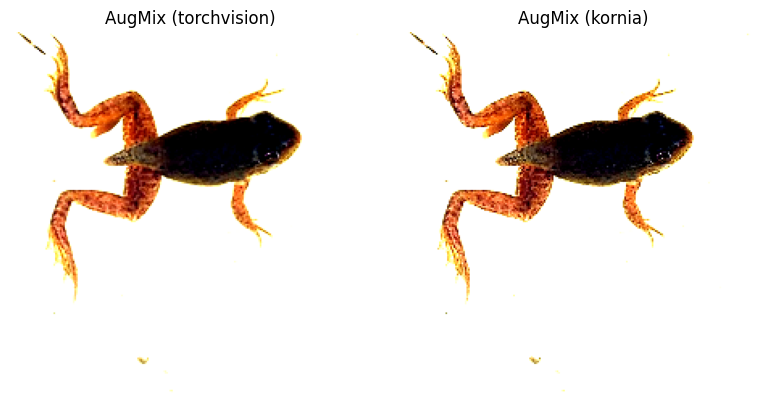

In [12]:
pil_image = torchvision.transforms.functional.to_pil_image(image)  # type: ignore

preprocessed_torchvision = preprocess(pil_image)

preprocessed_kornia = kornia_preprocess(image.float().div(255)).squeeze(0)

# Visuaize both on the same plot and row
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns

axes[0].imshow(preprocessed_torchvision.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("AugMix (torchvision)")
axes[0].axis("off")

axes[1].imshow(preprocessed_kornia.permute(1, 2, 0).cpu().numpy())
axes[1].set_title("AugMix (kornia)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Image-A Builder

Build the dataset and dataloader with image-agumentation at data-loading time.


In [7]:
def ImagenetA(
    augmenter: ImageTransform,
    root_dir="datasets/imagenet-a",
    num_workers=0,
):
    """
    Create a DataLoader for the ImageNet-A dataset. Defaults to 1 element per batch.
    Non modifiable. No shuffling.
    Args:
        augmenter (callable):
        root_dir (str): Root directory of the ImageNet-A dataset.

    Returns:
        dataloader (DataLoader): DataLoader for the ImageNet-A dataset.
        dataset (ImageNetADataset): The underlying dataset object.
    """

    def collate_fn(batch):
        """
        Custom collate function to handle the batch of images and labels.
        """

        images = batch[0][0]

        if images.ndim == 3:
            images = images.unsqueeze(0)

        labels = batch[0][1]

        return images, labels

    dataset = ImageNetADataset(root_dir=root_dir, transform=augmenter)
    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    return dataloader, dataset

## Benchmark

This is as simple benchmark function to easily and reliably test the performance of different TTA implementations. The idea is that images are fed in the same way to the model. The `forward` method of the model internally manages every detail of the TTA (image augmentation excluded).

Timing is done with cuda events, only on the `forward` method as we are mostly interested in the inference time of the model, not the data loading/augmentation time.


In [8]:
def bench(
    model: nn.Module,
    dataloader: DataLoader,
    device: str,
    comment: str,
    reduce: Optional[int | None] = None,
    visualize: Optional[bool] = False,
):
    """Benchmark the model on the dataset.

    The model must return logits.
    """
    today_now = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

    board = SummaryWriter(log_dir=f"runs/{today_now}/{comment}")

    total = 0
    correct = 0

    times = []

    total_tqdm = reduce if reduce is not None else len(dataloader)
    # ░▒█
    # ascii=" ▖▘▝▗▚▞█"
    # ascii=' >='
    start_event, end_event = torch.cuda.Event(enable_timing=True), torch.cuda.Event(
        enable_timing=True
    )
    for image, label in tqdm(dataloader, total=total_tqdm, ascii=" ▖▘▝▗▚▞█"):
        image = image.to(device)

        start_event.record()  # type: ignore
        pred_class = model(image)
        end_event.record()  # type: ignore
        torch.cuda.synchronize()

        times.append(start_event.elapsed_time(end_event))

        # del image
        # gc.collect()
        # torch.cuda.empty_cache()

        total += 1
        correct += int((pred_class == label))

        if reduce:
            if total > reduce:
                break

        # break
        board.add_scalar("accuracy", correct / total, total)
        board.add_scalar("dbg/label/predict_class", pred_class, total)
        board.add_scalar("dbg/label/label", label, total)

        running_accuracy = correct / total

        if visualize:
            print(f"[{label} || {pred_class}] | Acc: [{running_accuracy*100:.2f}%]")

    accuracy = correct / total
    latency = (np.array(times).sum() / total).item()  # ms

    board.add_scalar("metrics/latency (ms)", latency)
    board.add_scalar("metrics/accuracy", accuracy)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Latency: {latency:.2f} ms")

    return accuracy, latency

## Common


In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

augmenter = ImageTransform(
    model_transform=kornia_preprocess,
    custom_transform=kornia_random_crop,
    n_views=63,
    device="cpu",
)

dataloader, dataset = ImagenetA(augmenter, num_workers=5)

## Baseline - ZeroShot CLIP (OpenAI implementation and weights)

Simple baseline with CLIP using the OpenAI implementation and weights. The model is used in zero-shot: no training, no fine-tuning, no TTA. The model is used as it is, with a prompt of `a photo of a {class}` for each class in the dataset.


### Model


In [16]:
class ClipWrapper(nn.Module):
    def __init__(
        self,
        model: clip.model.CLIP,  # type:ignore
        class_labels: dict,
        prompt: str = "a photo of a {}",
        device: str = "cuda",
    ):
        super().__init__()
        self.device = device
        self.model = model
        self.logit_scale = model.logit_scale.exp()

        with torch.no_grad():
            prompts = torch.cat(
                [clip.tokenize(prompt.format(c)) for c in class_labels.values()]
            ).to(device)
            self.text_features = model.encode_text(prompts)
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)

    def forward(self, x: torch.Tensor) -> int:
        """
        Forward pass through the model.

        Returns the predicted class.
        """

        with torch.no_grad():
            image_features = self.model.encode_image(x)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = self.logit_scale * image_features @ self.text_features.t()
            marginal_prob = F.softmax(logits, dim=1).mean(0)
            pred_class = marginal_prob.argmax().item()

        return int(pred_class)

### Running


In [ ]:
clip_model, _ = clip.load("ViT-B/16", device=DEVICE, jit=False)
clip_model.eval()

wrapper_clip = ClipWrapper(
    clip_model, class_labels=dataset.class_code_to_label, device=DEVICE
).to(DEVICE)

bench(
    wrapper_clip,
    dataloader,
    DEVICE,
    reduce=N_SAMPLES,
    comment="baseline OpenAI",
    visualize=False,
)

# Cleaning
del clip_model
del wrapper_clip
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 100/100 [00:20<00:00,  4.77it/s]

Accuracy: 52.48%
Latency: 182.67 ms


(0.5247524752475248, 182.6725933717029)

## Baseline - ZeroShot CLIP (OpenCLIP implementation and OpenAI weights)

Simple baseline with CLIP using OpenCLIP implementation and OpenAI weights. The model is used in zero-shot as above.


### Model


In [19]:
class ClipWrapper(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        class_labels: dict,
        prompt: str = "a photo of a {}",
        device: str = "cuda",
    ):
        super().__init__()
        self.device = device
        self.class_labels = class_labels

        self.tokenizer = open_clip.get_tokenizer("ViT-B-16")
        self.model = model
        self.logit_scale = model.logit_scale.exp()

        # Precompute text features
        with torch.no_grad():
            prompts = torch.cat(
                [self.tokenizer(prompt.format(c)) for c in class_labels.values()]
            ).to(device)
            self.text_features = model.encode_text(prompts, normalize=True)

    def forward(self, x: torch.Tensor) -> int:
        with torch.no_grad(), torch.autocast("cuda"):
            image_features = self.model.encode_image(x, normalize=True)
            logits = self.logit_scale * image_features @ self.text_features.t()
            marginal_prob = F.softmax(logits, dim=1).mean(0)
            pred_class = marginal_prob.argmax().item()
        return int(pred_class)

### Running


In [ ]:
clip_model, _, _ = open_clip.create_model_and_transforms(
    model_name="ViT-B-16",
    pretrained="openai",
    device=DEVICE,
    force_quick_gelu=True,
    jit=False,
)
clip_model.eval()  #  type:ignore

# Create a ClipSkeleton instance
wrapper_clip = ClipWrapper(
    clip_model, class_labels=dataset.class_code_to_label, device=DEVICE  #  type:ignore
).to(DEVICE)

bench(
    wrapper_clip,
    dataloader,
    DEVICE,
    reduce=N_SAMPLES,
    comment="baseline OpenClip",
    visualize=False,
)

# Cleaning
del wrapper_clip
del clip_model
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 100/100 [00:22<00:00,  4.40it/s]

Accuracy: 53.47%
Latency: 181.56 ms


# 3. Reproducing TPT

TPT + "one-shot" Coop inspiration

The idea is to verify if TPT + CoOp with OpenCLIP implementation of CLIP and OpenAI weights and Kornia as image augmentator is equivalent to the original TPT + CoOp with OpenAI clip and weights and torchvision as image augmentator.

Kornia was used to try reduce latency in the image augmentation step, as it generally faster than torchvision.


### Implementation

- `TPTPromptLearner`: a simple TPT prompt learner, which has a similar amount of learnable parameters as the original TPT's prompt learner, but with a simpler and more readable implementation. The idea is to simplify how the prompt learner is structured: instead of having the `class_token_position` that can be in the `end`, `middle` or `front` as in the original TPT + CoOp model, we simply split the prompt is `pre` and `post` prompts, which are then concatenated with the current class token (embedded ofc). One thing to note is that the prompt initialization, as seen in CoOp [[4](#ref-coop2021)], is done with "a photo of a {}", without any pre-training, as performances are close.
- `TPTModel`: CLIP model with TPT+CoOp prompt learner.
- `TPT`: awesome wrapper that makes possible to manage the finetuning and reset of the model after each image, it's "invisible" to the user and painless.


In [10]:
# Note: from 5_tpt.py
@dataclass(frozen=True)
class CLIPModels:
    ViTB32: str = "ViT-B/32"


class TPTPromptLearner(nn.Module):
    def __init__(
        self,
        class_names: List[str],
        clip_model: open_clip.model.CLIP,
        arch: CLIPModels = CLIPModels.ViTB32,  # type: ignore
        base_prompt: str = "a photo of a [CLS]",
        device="cuda",
    ):
        super().__init__()
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.class_names = class_names

        tokenizer = open_clip.get_tokenizer(arch)

        self.__init_ctx_from_prompt(
            tokenizer=tokenizer,
            token_embedding=clip_model.token_embedding,
            base_prompt=base_prompt,
        )

    def __init_ctx_from_prompt(
        self, tokenizer, token_embedding, base_prompt: str
    ) -> None:
        """
        Initialize the context tokens from the base prompt.

        We need to make sure that the CLS token is NOT "exploded" in the prompt.

        The idea is to have prompts tuned without having to manually manage where the CLS token is.

        To do this we need to keep the CLS token position in the prompt, and update it accordingly
        when needed.

        I'm splitting the prompt into prefix and suffix, using [CLS] as a separator.
        They are trained as two different parameters, and then concatenated together.

        """

        # Split the base prompt into prefix and suffix
        promt_prefix = base_prompt.split("[CLS]")[0]
        promt_suffix = base_prompt.split("[CLS]")[1]

        # "Clean" PAD, SOT and EOT tokens
        c_token_sot = torch.tensor([[tokenizer.sot_token_id]]).to(self.device)
        c_token_eot = torch.tensor([[tokenizer.eot_token_id]]).to(self.device)
        c_token_pad = torch.tensor([[0]]).to(self.device)  # PAD

        # Tokenize prefix, suffix and class names
        tokenized_prefix = tokenizer(promt_prefix).to(self.device)
        tokenized_suffix = tokenizer(promt_suffix).to(self.device)

        # remove PAD, SOT and EOT tokens
        # Extract "clean" tokens
        c_tokenized_prefix = tokenized_prefix[
            (tokenized_prefix != c_token_sot)
            & (tokenized_prefix != c_token_eot)
            & (tokenized_prefix != c_token_pad)
        ].to(self.device)
        c_tokenized_suffix = tokenized_suffix[
            (tokenized_suffix != c_token_sot)
            & (tokenized_suffix != c_token_eot)
            & (tokenized_suffix != c_token_pad)
        ].to(self.device)

        tokenized_class_names = tokenizer(self.class_names).to(self.device)

        # BASE full prompt
        # [CLS] + prefix + class_name + suffix + EOT
        # pre-computed as it's used for all classes and images :)
        self.tokenized_initial_full_prompt = tokenizer(
            [base_prompt.replace("[CLS]", c) for c in self.class_names]
        ).to(self.device)

        # Get base embeddings
        with torch.no_grad():
            self.embedded_sot = token_embedding(c_token_sot)
            self.embedded_eot = token_embedding(c_token_eot)
            self.embedded_pad = token_embedding(c_token_pad)
            self.embedded_prefix = token_embedding(c_tokenized_prefix)
            self.embedded_suffix = token_embedding(c_tokenized_suffix)
            embedded_class_names = token_embedding(tokenized_class_names)
            self.embedded_max_len = embedded_class_names.shape[1]

        # Setup clean embedded_class_names (list)
        # Mask to filter out SOT/EOT/PAD tokens (shape [200, 77])
        mask = (
            (tokenized_class_names != c_token_sot)
            & (tokenized_class_names != c_token_eot)
            & (tokenized_class_names != c_token_pad)
        )

        # Apply mask to embeddings (for each class)
        clean_embeddings = []
        for i in range(embedded_class_names.shape[0]):
            # masked_select would flatten, so we use boolean indexing
            # [num_valid_tokens, 512]
            clean_embed = embedded_class_names[i][mask[i]]
            clean_embeddings.append(
                clean_embed.unsqueeze(0)
            )  # [1, num_valid_tokens, 512]

        self.embedded_class_names = clean_embeddings

        for i, embed in enumerate(clean_embeddings):
            self.register_buffer(f"class_embed_{i}", embed)

        # Create "init" states and set learnable parameters
        self.init_state_prefix = self.embedded_prefix.detach().clone()
        self.init_state_suffix = self.embedded_suffix.detach().clone()
        self.embedded_prefix = nn.Parameter(self.embedded_prefix)
        self.embedded_suffix = nn.Parameter(self.embedded_suffix)
        self.register_parameter("embedded_prefix", self.embedded_prefix)  # type: ignore
        self.register_parameter("embedded_suffix", self.embedded_suffix)  # type: ignore

    def forward(self) -> torch.Tensor:
        prompts = []
        for i in range(len(self.class_names)):

            # embeddeD_max_len: 77
            # embedded_prefix: torch.Size([4, 512])
            # embedded_class_names: torch.Size([1, 1, 512])
            # embedded_suffix: torch.Size([0, 512]

            padding_size = (
                self.embedded_max_len
                - self.embedded_prefix.shape[0]
                - getattr(self, f"class_embed_{i}").shape[1]
                - self.embedded_suffix.shape[0]
            ) - 2  # # -2 for SOT and EOT

            # embedded sot shape: torch.Size([1, 1, 512])
            # embedded prefix shape: torch.Size([1, 4, 512])
            # embedded class names shape: torch.Size([1, 1, 1, 512])
            # embedded suffix shape: torch.Size([1, 0, 512])
            # embedded eot shape: torch.Size([1, 1, 512])
            # effective padding shape: torch.Size([1, 70, 512])
            # Prompt shape: torch.Size([1, 77, 512])

            prompt = torch.cat(
                (
                    self.embedded_sot,
                    self.embedded_prefix.unsqueeze(0),
                    # self.embedded_class_names[i],
                    getattr(self, f"class_embed_{i}"),
                    self.embedded_suffix.unsqueeze(0),
                    self.embedded_eot,
                    self.embedded_pad.repeat(1, padding_size, 1),
                ),
                dim=1,
            )

            prompts.append(prompt)

        prompts = torch.cat(prompts, dim=0)
        # Must have shape torch.Size([200, 77, 512]) (classes, feature1, feature2)
        return prompts

    def reset(self) -> None:
        # TODO: check, doin without `data`

        # self.embedded_prefix.data.copy_(self.init_state_prefix)
        # self.embedded_suffix.data.copy_(self.init_state_suffix)
        with torch.no_grad():
            self.embedded_prefix.copy_(self.init_state_prefix)
            self.embedded_suffix.copy_(self.init_state_suffix)


class TPTModel(nn.Module):
    def __init__(
        self,
        class_names: List[str],
        arch: CLIPModels,
        pretrained: str,
        device="cuda",
    ):
        super().__init__()
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        clip_model: open_clip.model.CLIP
        clip_model, _, _ = open_clip.create_model_and_transforms(  # type:ignore
            model_name=arch,  # type:ignore
            pretrained=pretrained,
            device=device,
            force_quick_gelu=True,
        )

        self.model = clip_model
        self.model.eval()

        self.tokenizer = open_clip.get_tokenizer(arch)  # type:ignore
        self.class_names = class_names

        self.visual: open_clip.transformer.VisionTransformer = (  # type:ignore
            clip_model.visual
        )  # type:ignore
        self.visual.eval()

        self.token_embedding = clip_model.token_embedding

        self.positional_embedding = clip_model.positional_embedding
        self.transformer = clip_model.transformer
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.attn_mask = clip_model.attn_mask
        self.text_pool_type = clip_model.text_pool_type

        for _, param in self.named_parameters():
            param.requires_grad_(False)

        self.prompt_learner = TPTPromptLearner(
            arch=arch, class_names=class_names, clip_model=clip_model
        )

    def _pool(self, x: torch.Tensor):
        if self.visual.attn_pool is not None:
            if self.visual.attn_pool_contrastive is not None:
                # This is untested, WIP pooling that should match paper
                x = self.visual.ln_post(
                    x
                )  # TBD LN first or separate one after each pool?
                tokens = self.visual.attn_pool(x)
                if self.visual.attn_pool_type == "parallel":
                    pooled = self.visual.attn_pool_contrastive(x)
                else:
                    assert self.visual.attn_pool_type == "cascade"
                    pooled = self.visual.attn_pool_contrastive(tokens)
            else:
                # this is the original OpenCLIP CoCa setup, does not match paper
                x = self.visual.attn_pool(x)
                x = self.visual.ln_post(x)
                pooled, tokens = self.visual._global_pool(x)
        elif self.visual.final_ln_after_pool:
            pooled, tokens = self.visual._global_pool(x)
            pooled = self.visual.ln_post(pooled)
        else:
            x = self.visual.ln_post(x)
            pooled, tokens = self.visual._global_pool(x)

        return pooled, tokens, x

    def _forward_image(self, x: torch.Tensor) -> torch.Tensor:
        x = self.visual._embeds(x)
        x = self.visual.transformer(x)

        pooled, tokens, x = self._pool(x)

        if self.visual.proj is not None:
            pooled = pooled @ self.visual.proj
        if self.visual.output_tokens:
            return pooled, tokens, x  # type:ignore

        return pooled

    def __encode_image(
        self, image, normalize: bool = False
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        pooled_pre_norm = self._forward_image(image)
        return (
            F.normalize(pooled_pre_norm, dim=-1) if normalize else pooled_pre_norm
        )  # type:ignore

    def __encode_text(self, text=None, normalize: bool = False):
        cast_dtype = self.transformer.get_cast_dtype()

        x = self.prompt_learner().to(cast_dtype)

        text = self.prompt_learner.tokenized_initial_full_prompt

        x = x + self.positional_embedding.to(cast_dtype)
        x = self.transformer(x, attn_mask=self.attn_mask)
        x = self.ln_final(x)  # [batch_size, n_ctx, transformer.width]
        x = text_global_pool(x, text, self.text_pool_type)  # type:ignore
        if self.text_projection is not None:
            if isinstance(self.text_projection, nn.Linear):
                x = self.text_projection(x)
            else:
                x = x @ self.text_projection

        return F.normalize(x, dim=-1) if normalize else x

    def forward(self, image: torch.Tensor):
        """
        Inference function for the CLIP model.

        Args:
            images (torch.Tensor): Input images.
        Returns:
            logits (torch.Tensor): Logits from the CLIP model.
        """

        with torch.no_grad():
            image_features = self.__encode_image(image, normalize=True)
        text_features = self.__encode_text(normalize=True)

        logit_scale = self.model.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits, image_features

    def reset(self):
        """
        Reset the prompt learner to its initial state.
        """
        self.prompt_learner.reset()


class TPT(nn.Module):
    def __init__(
        self,
        pretrained: str,
        arch: CLIPModels,
        class_names: List[str],
        tta_steps: int = 1,
        lr: float = 0.0001,
        device="cuda",
    ):
        super().__init__()
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.tpt_steps = tta_steps

        model = TPTModel(
            class_names=class_names,
            arch=arch,
            pretrained=pretrained,
            device=self.device,
        )
        self.model = model.to(self.device)
        self.model.eval()

        # # # TEST - learnable layer norm
        # self.model.visual.ln_post.requires_grad_(True)
        # self.model.ln_final.requires_grad_(True)

        # Get all trainable parameters (filter by requires_grad)
        trainable_params = [p for p in self.model.parameters() if p.requires_grad]

        # Initialize optimizer with trainable parameters
        self.optim = torch.optim.AdamW(trainable_params, lr=lr)
        self.scaler = torch.cuda.amp.GradScaler()

        self.optim_init = deepcopy(self.optim.state_dict())

        # Initialize backup lists
        self.ln_backup = {
            "weights": [],  # For gamma (scale)
            "biases": [],  # For beta (shift)
        }

        # Backup all LN params in text encoder
        for block in self.model.transformer.resblocks:  # type:ignore
            self.ln_backup["weights"].append(
                block.ln_1.weight.data.detach().clone()
            )  # gamma for ln_1
            self.ln_backup["biases"].append(
                block.ln_1.bias.data.detach().clone()
            )  # beta for ln_1
            self.ln_backup["weights"].append(
                block.ln_2.weight.data.detach().clone()
            )  # gamma for ln_2
            self.ln_backup["biases"].append(
                block.ln_2.bias.data.detach().clone()
            )  # beta for ln_2

        # Backup final LN
        self.ln_backup["weights"].append(
            self.model.ln_final.weight.data.detach().clone()
        )
        self.ln_backup["biases"].append(self.model.ln_final.bias.data.detach().clone())

    def set_tta_steps(self, tta_steps: int) -> None:
        """
        Set the number of TTA steps.

        Args:
            tta_steps (int): Number of TTA steps.
        """
        self.tpt_steps = tta_steps

    def forward(self, input: torch.Tensor):
        selected_idx = None

        for step in range(self.tpt_steps):
            with torch.cuda.amp.autocast():

                logits, image_features = self.model(input)

                # Select the most confident samples
                if selected_idx is not None:
                    logits = logits[selected_idx]
                else:
                    logits, selected_idx = self.select_confident_samples(logits)

                # Compute the average entropy loss
                loss = self.avg_entropy_loss(logits)

            self.optim.zero_grad()
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optim)
            self.scaler.update()

        # Actual inference
        with torch.no_grad(), torch.autocast("cuda"):
            # take only the last image of the input
            # input = input[-1].unsqueeze(0)
            logits, _ = self.model(input)

            marginal_prob = F.softmax(logits, dim=1).mean(0)
            pred_class = marginal_prob.argmax().item()

        self.reset()

        return pred_class

    def select_confident_samples(
        self, logits: torch.Tensor, top: float = 0.1
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Selects the top-k samples with the lowest entropy from the logits.

        Args:
            logits (torch.Tensor): The logits from the model.
            top (float): The fraction of samples to select.
                For example, if top=0.1, it selects the top 10% of samples.
        Returns:
            torch.Tensor: The selected logits.
            torch.Tensor: The indices of the selected samples.

        [Reference](https://github.com/azshue/TPT/blob/63ecbace79694205d7884e63fdc3137a200f0b0e/tpt_classification.py#L41C5-L41C11)
        """
        batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
        idx = torch.argsort(batch_entropy, descending=False)[
            : int(batch_entropy.size()[0] * top)
        ]

        return logits[idx], idx

    def avg_entropy_loss(self, outputs: torch.Tensor) -> torch.Tensor:
        """
        Computes the average entropy of the model's outputs.
        Args:
            outputs (torch.Tensor): The model's outputs.
        Returns:
            torch.Tensor: The average entropy.

        [Reference](https://github.com/azshue/TPT/blob/63ecbace79694205d7884e63fdc3137a200f0b0e/tpt_classification.py#L46)
        """
        logits = outputs - outputs.logsumexp(
            dim=-1, keepdim=True
        )  # logits = outputs.log_softmax(dim=1) [N, 1000]
        avg_logits = logits.logsumexp(dim=0) - np.log(
            logits.shape[0]
        )  # avg_logits = logits.mean(0) [1, 1000]
        min_real = torch.finfo(avg_logits.dtype).min
        avg_logits = torch.clamp(avg_logits, min=min_real)

        return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

    def reset(self) -> None:
        """Full reset of prompt learner and optimizer state"""
        # 1. Reset prompt embeddings
        for p in self.model.parameters():
            p.grad = None

        self.model.reset()

        # with torch.no_grad():
        #     self.embedded_prefix.copy_(self.init_state_prefix)
        #     self.embedded_suffix.copy_(self.init_state_suffix)

        with torch.no_grad():
            idx = 0
            # Reset LN params in text encoder
            for block in self.model.transformer.resblocks:  # type:ignore
                block.ln_1.weight.data.copy_(self.ln_backup["weights"][idx].clone())
                block.ln_1.bias.data.copy_(self.ln_backup["biases"][idx].clone())
                idx += 1
                block.ln_2.weight.data.copy_(self.ln_backup["weights"][idx].clone())
                block.ln_2.bias.data.copy_(self.ln_backup["biases"][idx].clone())
                idx += 1

            # # Reset final LN
            self.model.ln_final.weight.data.copy_(self.ln_backup["weights"][-1].clone())
            self.model.ln_final.bias.data.copy_(self.ln_backup["biases"][-1].clone())

        # # 2. Reset optimizer state
        self.optim.load_state_dict(deepcopy(self.optim_init))

### Running


In [38]:
wrapper_clip = TPT(
    arch="ViT-B-16",  # type:ignore
    pretrained="openai",
    class_names=dataset.class_code_to_label.values(),  # type:ignore
    tta_steps=1,
    lr=5e-3,
)

bench(
    wrapper_clip, dataloader, DEVICE, reduce=N_SAMPLES, comment="TPT", visualize=False
)

# Cleaning
del wrapper_clip
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


Accuracy: 62.38%
Latency: 807.33 ms


# 4. Trying to get better at TTA


TPT with CoOp is quite slow due to the finetuning of the prompt. The idea is to try to get better or similar performances getting inspiration form TPT and other TTA methods, but, possibly, without any weight updates (as backpropagation).


## Common Base Model

As the main differences mostly rely in the forward method, this skeleton is provided to avoid code duplication.


In [11]:
class ClipBaseline(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        class_labels: dict,
        prompt: str = "a photo of a {}",
        device: str = "cuda",
    ):
        super().__init__()
        self.device = device

        self.tokenizer = open_clip.get_tokenizer("ViT-B-16")
        self.model: open_clip.model.CLIP = model
        self.logit_scale = model.logit_scale.data.exp()
        # self.logit_scale = model.log

        with torch.no_grad():
            prompts = torch.cat(
                [self.tokenizer(prompt.format(c)) for c in class_labels.values()]
            ).to(device)
            self.text_features = model.encode_text(prompts, normalize=True)

    def select_confident_samples(
        self, logits: torch.Tensor, top: float = 0.1
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Selects the top-k samples with the lowest entropy from the logits.

        Args:
            logits (torch.Tensor): The logits from the model.
            top (float): The fraction of samples to select.
                For example, if top=0.1, it selects the top 10% of samples.
        Returns:
            torch.Tensor: The selected logits.
            torch.Tensor: The indices of the selected samples.

        [Reference](https://github.com/azshue/TPT/blob/63ecbace79694205d7884e63fdc3137a200f0b0e/tpt_classification.py#L41C5-L41C11)
        """
        batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
        idx = torch.argsort(batch_entropy, descending=False)[
            : int(batch_entropy.size()[0] * top)
        ]

        return logits[idx], idx

## A. Top 10% 🚀

The idea is to remove the prompt learner (CoOp style) from the TPT model and use the most confident samples logits (top 1%) and the original image ones, average them and use the average logits as the final prediction.

We want to keep the most confident samples logits, as they are the ones that are more likely to be correct, and average them with the original image logits, to avoid getting a too biased prediction and "losing context".

<blockquote>

```python
final_logits = torch.cat((selected_logits, initial_logits), dim=0)

marginal_prob = F.softmax(final_logits, dim=1).mean(0)
pred_class = int(marginal_prob.argmax().item())
```

</blockquote>

- `initial_logits`: the logits of the original image

We expect this to be way faster than TPT (as no finetuning is done) and to have slightly better performances, as we are using the most confident samples logits, which are more likely to be correct, and keeping the original image logits to avoid getting a _too biased_ prediction.

- Why the "biased prediction"? Because the augmentations are random crop, so the model might be biased towards the augmented images, which might not be representative of the original image. By averaging the logits, we can mitigate this bias and get a more reliable prediction.
- Is this the best method to do this? No, but it's a good starting point, it's simple and it works well in practice.


### Model


In [ ]:
class ClipWrapper(ClipBaseline):
    def __init__(
        self,
        model: nn.Module,
        class_labels: dict,
        prompt: str = "a photo of a {}",
        device: str = "cuda",
    ):
        super().__init__(model, class_labels, prompt, device)

    def forward(self, x: torch.Tensor) -> int:
        with torch.no_grad(), torch.autocast("cuda"):
            image_features = self.model.encode_image(x, normalize=True)

            initial_image_features = image_features[-1:]
            filtered_image_features = image_features[:-1:]

            # filter logits
            initial_logits = (
                self.logit_scale * initial_image_features @ self.text_features.t()
            )
            filtered_logits = (
                self.logit_scale * filtered_image_features @ self.text_features.t()
            )

            # Get top k logits
            selected_logits, _ = self.select_confident_samples(
                # filtered_logits, top=1 / filtered_logits.shape[0]
                filtered_logits,
                top=0.1,
            )

            # selected_logits = selected_logits.mean(0, keepdim=True)

            # final_logits = selected_logits
            final_logits = torch.cat((selected_logits, initial_logits), dim=0)

            marginal_prob = F.softmax(final_logits, dim=1).mean(0)
            pred_class = int(marginal_prob.argmax().item())

        return pred_class

### Running


In [ ]:
clip_model, _, _ = open_clip.create_model_and_transforms(
    model_name="ViT-B-16",
    pretrained="openai",
    device=DEVICE,
    force_quick_gelu=True,
)
clip_model.eval()  # type:ignore

# Create a ClipSkeleton instance
wrapper_clip = ClipWrapper(
    clip_model, class_labels=dataset.class_code_to_label, device=DEVICE  # type:ignore
).to(DEVICE)

bench(
    wrapper_clip, dataloader, DEVICE, reduce=N_SAMPLES, comment="Top10", visualize=False
)

# Cleaning
del wrapper_clip
del clip_model
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 100/100 [00:20<00:00,  4.79it/s]

Accuracy: 46.53%
Latency: 183.95 ms


## B. TPT with Top 10

The idea is pretty simple: use the top 10 + original image logits as specified above, but on TPT w/ CoOp.

The implementation is straightforward: override the `forward` method of the `TPT` class (the one which manages the finetuning of the `TPTModel`), so that it uses the top 10 + original image logits instead of the prompt learner. Note that the finetuning of the model is kept as is, only the final prediction is changed.

**Diff**:

<blockquote>

```python
with torch.no_grad(), torch.autocast("cuda"):
            # take only the last image of the input
            logits, _ = self.model(input)

            original_logits = logits[-1:]
            filtered_logits = logits[:-1:]

            # Get top k logits
            selected_logits, _ = self.select_confident_samples(
                filtered_logits,
                top=0.1,
            )

            final_logits = torch.cat((selected_logits, original_logits), dim=0)

            marginal_prob = F.softmax(final_logits, dim=1).mean(0)
            pred_class = marginal_prob.argmax().item()
```

</blockquote>


### Model


In [12]:
class TPTTop10(TPT):
    def __init__(
        self,
        pretrained: str,
        arch: CLIPModels,
        class_names: List[str],
        tta_steps: int = 1,
        lr: float = 0.0001,
        device="cuda",
    ):
        super().__init__(
            pretrained=pretrained,
            arch=arch,
            class_names=class_names,
            tta_steps=tta_steps,
            lr=lr,
            device=device,
        )

    def forward(self, input: torch.Tensor):
        selected_idx = None

        for step in range(self.tpt_steps):
            with torch.cuda.amp.autocast():

                logits, image_features = self.model(input)

                # Select the most confident samples
                if selected_idx is not None:
                    logits = logits[selected_idx]
                else:
                    logits, selected_idx = self.select_confident_samples(logits)

                # Compute the average entropy loss
                loss = self.avg_entropy_loss(logits)

            self.optim.zero_grad()
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optim)
            self.scaler.update()

        # Actual inference
        with torch.no_grad(), torch.autocast("cuda"):
            # take only the last image of the input
            logits, _ = self.model(input)

            original_logits = logits[-1:]
            filtered_logits = logits[:-1:]

            # Get top k logits
            selected_logits, _ = self.select_confident_samples(
                filtered_logits,
                top=0.1,
            )

            final_logits = torch.cat((selected_logits, original_logits), dim=0)

            marginal_prob = F.softmax(final_logits, dim=1).mean(0)
            pred_class = marginal_prob.argmax().item()

        self.reset()

        return pred_class

In [55]:
del wrapper_clip
gc.collect()
torch.cuda.empty_cache()

### Running


In [ ]:
wrapper_clip = TPTTop10(
    arch="ViT-B-16",  # type:ignore
    pretrained="openai",
    class_names=dataset.class_code_to_label.values(),  # type:ignore
    tta_steps=1,
    lr=5e-3,
)

bench(
    wrapper_clip,
    dataloader,
    DEVICE,
    reduce=N_SAMPLES,
    comment="TPT-Top10",
    visualize=False,
)

# Cleaning
del TPT
del TPTTop10
del wrapper_clip
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]

Accuracy: 55.45%
Latency: 806.66 ms


## C. TNT 🧨

TODO: add amount of learnable parameters wrt TPT

Implementation of TNT [[6](#ref-tnt2023)]. It's pretty straightforward, it's CLIP with learnable random noise on the augmented images (noise shape: `(3, height, width)`).

We expect this to be slightly faster than TPT, and have slightly better performances, as in the paper.


### Model


In [ ]:
class TNT(ClipBaseline):
    def __init__(
        self,
        model: nn.Module,
        class_labels: dict,
        prompt: str = "a photo of a {}",
        device: str = "cuda",
        tnt_steps: int = 3,
        top_k: float = 0.1,
        epsilon: float = 1 / 255,
        lr: float = 1e-3,
        alpha: float = 1.0,
        beta: float = 1.0,
        temperature: float = 7e-3,
    ):
        super().__init__(
            model=model, class_labels=class_labels, prompt=prompt, device=device
        )
        self.tokenizer = open_clip.get_tokenizer("ViT-B-16")
        self.tnt_steps = tnt_steps
        self.top_k = top_k
        self.eps = epsilon
        self.lr = lr
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature

        with torch.no_grad():
            prompts = torch.cat(
                [self.tokenizer(prompt.format(c)) for c in class_labels.values()]
            ).to(device)
            self.text_features = model.encode_text(prompts, normalize=True)

        self.noise = None

    def reset(self):
        self.noise = None

    def forward(self, x: torch.Tensor) -> int:
        x = x.to(self.device)

        if self.noise is None:
            self.noise = torch.randn_like(
                x[0], requires_grad=True, device=self.device
            )  # , dtype=torch.float16)
            self.noise.data = self.noise.clamp(-self.eps, self.eps)

        self.noise.requires_grad = True

        with torch.autocast(self.device):  # , dtype=torch.float16):
            for _ in range(self.tnt_steps):
                # x_aug = x + torch.clamp(self.noise, 0, 1)[None, ...]
                x_aug = x + self.noise[None, ...].clamp(0, 1)

                image_features = self.model.encode_image(x_aug, normalize=True)
                logits = self.logit_scale * image_features @ self.text_features.t()

                # Select top-k logits
                top_logits, top_idx = self.select_confident_samples(
                    logits, top=self.top_k
                )
                top_features = image_features[top_idx]

                # Entropy loss
                prob = F.softmax(top_logits, dim=1).mean(dim=0)
                entropy_loss = -(prob * prob.log()).sum()

                # Inter-view consistency loss
                pairwise_dist = torch.cdist(top_features, top_features, p=2)
                inter_view_loss = pairwise_dist.sum()

                # Total loss
                loss = self.alpha * entropy_loss + self.beta * inter_view_loss
                loss.backward()

                # Update noise
                with torch.no_grad():
                    grad = self.noise.grad
                    self.noise -= self.lr * grad.sign()  #  type:ignore
                    self.noise.clamp_(-self.eps, self.eps)
                    self.noise.requires_grad = True
                    self.noise.grad = None

        with torch.no_grad(), torch.autocast(self.device):
            x_aug = x + self.noise[None, ...].clamp(0, 1)[-1:]
            image_features = self.model.encode_image(x_aug, normalize=True)
            logits = self.logit_scale * image_features @ self.text_features.t()
            probs = F.softmax(logits / self.temperature, dim=1).mean(dim=0)
            pred_class = int(probs.argmax().item())

        return pred_class

### Running


In [17]:
clip_model, _, _ = open_clip.create_model_and_transforms(
    # model_name="ViT-B-32", pretrained="datacomp_xl_s13b_b90k", device=device#, force_quick_gelu=True
    model_name="ViT-B-16",
    pretrained="openai",
    device=DEVICE,
    force_quick_gelu=True,
)
clip_model.eval()  # type:ignore

# Set the model to evaluation mode
for param in clip_model.parameters():  # type:ignore
    param.requires_grad = False

# Create a ClipSkeleton instance
wrapper_clip = TNT(
    clip_model,  # type:ignore
    class_labels=dataset.class_code_to_label,
    device=DEVICE,
    tnt_steps=1,  # type:ignore
).to(DEVICE)


bench(
    wrapper_clip, dataloader, DEVICE, reduce=N_SAMPLES, comment="TnT", visualize=False
)

# Cleaning
del wrapper_clip
del clip_model
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Accuracy: 50.50%
Latency: 647.98 ms


## D. TNT + Top10

It's the same as TNT, but with the top 1 + original image logits as final prediction.

We expect this to be slightly more accurate than TNT.

**Diff**:

<blockquote>

```python
with torch.no_grad(), torch.autocast(self.device):
            x_aug = x + self.noise[None, ...].clamp(0, 1)
            image_features = self.model.encode_image(x_aug, normalize=True)
            logits = self.logit_scale * image_features @ self.text_features.t()

            selected_logits, _ = self.select_confident_samples(
                logits[:-1], top=self.top_k
            )
            final_logits = torch.cat((selected_logits, logits[-1:]), dim=0)
            probs = F.softmax(final_logits / self.temperature, dim=1).mean(dim=0)
            pred_class = int(probs.argmax().item())
```

</blockquote>


### Model

In [23]:
class TNTTop10(TNT):
    def __init__(
        self,
        model: nn.Module,
        class_labels: dict,
        prompt: str = "a photo of a {}",
        device: str = "cuda",
        tnt_steps: int = 3,
        top_k: float = 0.1,
        epsilon: float = 1 / 255,
        lr: float = 1e-3,
        alpha: float = 1.0,
        beta: float = 1.0,
        temperature: float = 7e-3,
    ):
        super().__init__(
            model=model,
            class_labels=class_labels,
            prompt=prompt,
            device=device,
            tnt_steps=tnt_steps,
            top_k=top_k,
            epsilon=epsilon,
            lr=lr,
            alpha=alpha,
            beta=beta,
            temperature=temperature,
        )

    def forward(self, x: torch.Tensor) -> int:
        x = x.to(self.device)

        if self.noise is None:
            self.noise = torch.randn_like(
                x[0], requires_grad=True, device=self.device
            )  # , dtype=torch.float16)
            self.noise.data = self.noise.clamp(-self.eps, self.eps)

        self.noise.requires_grad = True

        with torch.autocast(self.device):  # , dtype=torch.float16):
            for _ in range(self.tnt_steps):
                # x_aug = x + torch.clamp(self.noise, 0, 1)[None, ...]
                x_aug = x + self.noise[None, ...].clamp(0, 1)

                image_features = self.model.encode_image(x_aug, normalize=True)
                logits = self.logit_scale * image_features @ self.text_features.t()

                # Select top-k logits
                top_logits, top_idx = self.select_confident_samples(
                    logits, top=self.top_k
                )
                top_features = image_features[top_idx]

                # Entropy loss
                prob = F.softmax(top_logits, dim=1).mean(dim=0)
                entropy_loss = -(prob * prob.log()).sum()

                # Inter-view consistency loss
                pairwise_dist = torch.cdist(top_features, top_features, p=2)
                inter_view_loss = pairwise_dist.sum()

                # Total loss
                loss = self.alpha * entropy_loss + self.beta * inter_view_loss
                loss.backward()

                # Update noise
                with torch.no_grad():
                    grad = self.noise.grad
                    self.noise -= self.lr * grad.sign()  # type:ignore
                    self.noise.clamp_(-self.eps, self.eps)
                    self.noise.requires_grad = True
                    self.noise.grad = None

        with torch.no_grad(), torch.autocast(self.device):
            x_aug = x + self.noise[None, ...].clamp(0, 1)
            image_features = self.model.encode_image(x_aug, normalize=True)
            logits = self.logit_scale * image_features @ self.text_features.t()

            selected_logits, _ = self.select_confident_samples(
                logits[:-1], top=self.top_k
            )
            final_logits = torch.cat((selected_logits, logits[-1:]), dim=0)
            probs = F.softmax(final_logits / self.temperature, dim=1).mean(dim=0)
            pred_class = int(probs.argmax().item())

        return pred_class

### Running


In [26]:
clip_model, _, _ = open_clip.create_model_and_transforms(
    model_name="ViT-B-16",
    pretrained="openai",
    device=DEVICE,
    force_quick_gelu=True,
)
clip_model.eval()  # type:ignore

# Set the model to evaluation mode
for param in clip_model.parameters():  # type:ignore
    param.requires_grad = False

# Create a ClipSkeleton instance
wrapper_clip = TNTTop10(
    clip_model,  # type:ignore
    class_labels=dataset.class_code_to_label,
    device=DEVICE,
    tnt_steps=1,  # type:ignore
).to(DEVICE)


bench(
    wrapper_clip, dataloader, DEVICE, reduce=N_SAMPLES, comment="TnT-Top10", visualize=False
)

# Cleaning
del wrapper_clip
del clip_model
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/100 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB. GPU 

## E. Test Time Clustering (TTC)

The idea here is to apply a clustering algorithm (Spectral Clustering) to the test image and its augmented views. We keep just the cluster containing the original image for the final prediction. In this way, we keep only the images similar to the original image, while filtering out the augmented views that maybe changed the semantic content of the image too much. The prediction is made with the averaged probabilities of the images in the selected cluster.

Spectral clustering groups image features based on their pairwise cosine similarities by treating them as nodes in a graph, where edges represent similarity. The model computes a similarity (affinity) matrix, converts it into a graph Laplacian, and uses its eigenvectors to embed the data in a lower-dimensional space. K-means clustering is then applied in this space to assign images to clusters. We use spectral clustering, instead of other algorithms (e.g. K-means), because it allows us to work with similarities. Opposed to just the spatial positions.

Additionally, the number of cluster is decided dynamically using the silhoutte score. The silhouette score measures how well a data point fits within its assigned cluster compared to other clusters. It ranges from -1 to 1, where a high score indicates that the point is well-matched to its own cluster and poorly matched to neighboring clusters. Specifically, it considers the average distance to points in the same cluster (intra-cluster) versus the nearest other cluster (inter-cluster). Averaging these scores across all points gives an overall measure of clustering quality, with higher values suggesting more distinct and well-separated clusters.

### Model

In [ ]:
class ClipWrapper(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        class_labels: dict,
        prompt: str = "a photo of a {}",
        device: str = "cuda",
        n_clusters: int = 3,
        dynamic_clusters: bool = False,
    ):
        super().__init__()
        self.device = device
        self.class_labels = class_labels

        self.tokenizer = open_clip.get_tokenizer("ViT-B-16")
        self.model = model
        self.logit_scale = model.logit_scale.exp()
        self.n_clusters = n_clusters
        self.dynamic_clusters = dynamic_clusters

        # Precompute text features
        with torch.no_grad():
            prompts = torch.cat(
                [self.tokenizer(prompt.format(c)) for c in class_labels.values()]
            ).to(device)
            self.text_features = model.encode_text(prompts, normalize=True)

        self.clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)

    @staticmethod
    def best_cluster_count(affinity_matrix, max_clusters=8):
        best_score = -1
        best_n = 2  # Start from 2 since 1 gives undefined silhouette
        for nr_clusters in range(2, max_clusters + 1):
            clustering = SpectralClustering(n_clusters=nr_clusters, affinity='precomputed', random_state=42)
            labels = clustering.fit_predict(affinity_matrix)
            if len(set(labels)) == 1:  # Silhouette score is undefined for 1 cluster
                continue
            try:
                score = silhouette_score(affinity_matrix, labels, metric="precomputed")
                if score > best_score:
                    best_score = score
                    best_n = nr_clusters
            except Exception:
                continue  # Skip cases where silhouette can't be computed
        return best_n # Return the best_n found or the initial 2 if loop completes without finding a better score

    def forward(self, x: torch.Tensor) -> int:
        with torch.no_grad(), torch.autocast("cuda"):
            image_features = self.model.encode_image(x, normalize=True)

            # Cosine similarity matrix
            sim_matrix = image_features @ image_features.T
            affinity = sim_matrix.detach().cpu().numpy()
            affinity[affinity < 0] = 0.0  # Threshold negative similarities

            # If dynamic clustering is enabled, determine optimal cluster count and update clustering model
            if self.dynamic_clusters:
                best_n = self.best_cluster_count(affinity)
                self.clustering = SpectralClustering(n_clusters=best_n, affinity='precomputed', random_state=42)

            # Perform clustering and find features in the same cluster as the original image (last image)
            cluster_labels = self.clustering.fit_predict(affinity)
            original_cluster = cluster_labels[-1]
            selected_indices = [i for i, lbl in enumerate(cluster_labels) if lbl == original_cluster]

            # Classify based on features in the same cluster
            selected_features = image_features[selected_indices]
            logits = self.logit_scale * selected_features @ self.text_features.T
            marginal_prob = F.softmax(logits, dim=1).mean(0)
            pred_class = marginal_prob.argmax().item()


            return pred_class

### Running


In [ ]:
# Load the CLIP model
clip_model, _, _ = open_clip.create_model_and_transforms(
    # model_name="ViT-B-32", pretrained="datacomp_xl_s13b_b90k", device=device#, force_quick_gelu=True
    model_name="ViT-B-16",
    pretrained="openai",
    device=DEVICE,
    force_quick_gelu=True,
)
clip_model.eval()

# Create a ClipSkeleton instance
wrapper_clip = ClipWrapper(
    clip_model, class_labels=dataset.class_code_to_label, device=DEVICE, dynamic_clusters=True
).to(DEVICE)

bench(wrapper_clip, dataloader, DEVICE, reduce=N_SAMPLES, comment="spectral_clust_dyn", visualize=False)

# Cleaning
del wrapper_clip
del clip_model
gc.collect()
torch.cuda.empty_cache()

## F. Image Masking 🤦‍♂️

Taking inspiration from the idea of masking the image, as done in [DinoV2](https://arxiv.org/abs/2304.07193), for visualizing the foreground and the background, we can try to mask the image (and its augmented views) and use the masked image(s) to make the final predictions, using the most confident sample logits (top 10%). 

We don't expect much improvement from this method, as CLIP is not trained to work with masked images, nor it's trained to split foreground and background. Also the CLIP model we are using is ViT based, so, by being a transformer-based architecture it shouldn't need a "guide" on what to focus on the image, and these maskings are probably going to just reduce the context and the relevant predictions. But it can be interesting to see how it performs and to visualize how CLIP (doesn't) separate foreground and background.

As CLIP doesn't have a specific foreground and background separation, we use two masks:
- positive: thresholded $> 0.6$ 
- negative: thresholded $< 0.4$ (as in DinoV2)

🤿
The visual encoder of a model sometimes could be distracted when watching to the whole image.
So a bit inspired by attention mechanisms, we wanted to try systems to augment TPT by masking features unused by the visual encoder.
Once generated the augmentations of the image we make generate a mask for each augmentation. 
Since we are working with the VIT based CLIP, our features are linked to the patches used for the visual tokens.
The idea is to obscure what are the unused patches and see what are the results.
In some of the images, the central object of the image has less activations then the rest of the image. So to avoid that the central image is masked out we also generate the negative of the mask.

Many methods were developed, they performed the same (or pretty close) the most notable are the following:
### F.1
1. image_features, tokens = model.visual(x)
2. perform pca on patch_embeddings
3. apply masks on the images
    - Both positive and negative masks
4. encode and get logits again
5. keep top-k
6. average logits and get the final prediction
### F.2
1. image_features, tokens = model.visual(x)
2. keep top-k
3. apply masks on the images
    - Both positive and negative masks
4. encode and get logits again
5. average logits and get the final prediction *there's also a version that uses the logits of the original image


### Model

In [ ]:
class ClipWrapper(ClipBaseline):
    def __init__(
        self,
        model: nn.Module,
        class_labels: dict,
        prompt: str = "a photo of a {}",
        device: str = "cuda",
    ):
        super().__init__(model, class_labels, prompt, device)

    def forward(self, x: torch.Tensor) -> int:
        with torch.no_grad():  # , torch.autocast("cuda"):
            clip_model.visual.output_tokens = True  # type: ignore

            image_features, tokens = self.model.visual(x)

            # Calcualte PCA (n_components=1) of each of the selected tokens
            # Assuming patch_embeddings is a tensor of shape [64, 50, 768]
            batch_size, num_patches, feat_dim = tokens.shape
            PATCH_RES = int(num_patches**0.5)  # Assuming num_patches is a square number

            # Center the data (subtract mean)
            patch_embeddings_centered = tokens - tokens.mean(dim=1, keepdim=True)

            U, S, V = torch.pca_lowrank(patch_embeddings_centered, q=1, center=False)

            # Project the data (get the first principal component scores)
            fg_scores = torch.matmul(
                patch_embeddings_centered, V[:, :, -1:]
            )  # [64, 50, 1]

            # Min-max scaling per image
            min_vals = fg_scores.min(dim=1, keepdim=True)[0]
            max_vals = fg_scores.max(dim=1, keepdim=True)[0]
            fg_scores_scaled = (fg_scores - min_vals) / (
                max_vals - min_vals + 1e-8
            )  # [64, 50, 1]

            # Reshape to [64, PATCH_RES, PATCH_RES]
            fg_scores_reshaped = fg_scores_scaled.view(batch_size, PATCH_RES, PATCH_RES)

            # Create mask
            positive_mask = fg_scores_reshaped > 0.6
            negative_mask = fg_scores_reshaped < 0.4

            positive_masked = x.clone()
            negative_masked = positive_masked.clone()

            positive_mask = F.interpolate(
                positive_mask.unsqueeze(1).float(),  # Add channel dimension
                size=(x.shape[2], x.shape[3]),  # Resize to input image size
                mode="nearest",
            )

            negative_mask = F.interpolate(
                negative_mask.unsqueeze(1).float(),  # Add channel dimension
                size=(x.shape[2], x.shape[3]),  # Resize to input image size
                mode="nearest",
            )

            positive_masked = positive_masked * positive_mask
            negative_masked = negative_masked * (1 - negative_mask)

            # Calculate the logits for the positive and negative masked images
            clip_model.visual.output_tokens = False  # type: ignore

            pos_logits = self.model.encode_image(positive_masked, normalize=True)
            neg_logits = self.model.encode_image(negative_masked, normalize=True)

            pos_logits = torch.cat((pos_logits, image_features[-1:]), dim=0)
            neg_logits = torch.cat((neg_logits, image_features[-1:]), dim=0)

            # Calculate the cosine similarity between the positive and negative logits
            pos_logits = pos_logits @ self.text_features.T * self.logit_scale
            neg_logits = neg_logits @ self.text_features.T * self.logit_scale

            all_logits = torch.cat((pos_logits, neg_logits), 0)
            selected_logits, idx = self.select_confident_samples(
                logits=all_logits, top=0.1
            )

            all_marginal_prob = F.softmax(selected_logits, dim=1).mean(0)

            pred_class = int(all_marginal_prob.argmax().item())
        # # type 2
        # with torch.no_grad():  # , torch.autocast("cuda"):
        #     clip_model.visual.output_tokens = True  # type: ignore

        #     # Patch embedding: (batch_size, num_patches + 1, embed_dim)
        #     image_features, tokens = self.model.visual(x)

        #     image_features = F.normalize(image_features, dim=-1)

        #     filtered_logits = (
        #         self.logit_scale * image_features[:-1:] @ self.text_features.T
        #     )

        #     selected_logits, idx = self.select_confident_samples(
        #         logits=filtered_logits, top=0.1
        #     )

        #     # selected_tokens = torch.cat((tokens[idx], tokens[-1:]), dim=0) # semplice
        #     selected_tokens = tokens[idx]  # coso_separato

        #     # Calcualte PCA (n_components=1) of each of the selected tokens
        #     # Assuming patch_embeddings is a tensor of shape [64, 50, 768]
        #     batch_size, num_patches, feat_dim = selected_tokens.shape
        #     PATCH_RES = int(num_patches**0.5)  # Assuming num_patches is a square number

        #     # Center the data (subtract mean)
        #     patch_embeddings_centered = selected_tokens - selected_tokens.mean(
        #         dim=1, keepdim=True
        #     )

        #     U, S, V = torch.pca_lowrank(patch_embeddings_centered, q=1, center=False)

        #     # Project the data (get the first principal component scores)
        #     fg_scores = torch.matmul(
        #         patch_embeddings_centered, V[:, :, -1:]
        #     )  # [64, 50, 1]

        #     # Min-max scaling per image
        #     min_vals = fg_scores.min(dim=1, keepdim=True)[0]
        #     max_vals = fg_scores.max(dim=1, keepdim=True)[0]
        #     fg_scores_scaled = (fg_scores - min_vals) / (
        #         max_vals - min_vals + 1e-8
        #     )  # [64, 50, 1]

        #     # Reshape to [64, PATCH_RES, PATCH_RES]
        #     fg_scores_reshaped = fg_scores_scaled.view(batch_size, PATCH_RES, PATCH_RES)

        #     # Create mask
        #     positive_mask = fg_scores_reshaped > 0.6
        #     negative_mask = fg_scores_reshaped < 0.4

        #     # Apply mask on the input (x) on the specific indices
        #     positive_masked = x[idx].clone()
        #     negative_masked = positive_masked.clone()

        #     positive_mask = F.interpolate(
        #         positive_mask.unsqueeze(1).float(),  # Add channel dimension
        #         size=(x.shape[2], x.shape[3]),  # Resize to input image size
        #         mode="nearest",
        #     )

        #     negative_mask = F.interpolate(
        #         negative_mask.unsqueeze(1).float(),  # Add channel dimension
        #         size=(x.shape[2], x.shape[3]),  # Resize to input image size
        #         mode="nearest",
        #     )

        #     positive_masked_p = positive_masked * positive_mask  # .bool()
        #     negative_masked_p = negative_masked * (1 - positive_mask)  # .bool()
        #     positive_masked_n = positive_masked * negative_mask  # .bool()
        #     negative_masked_n = negative_masked * (1 - negative_mask)  # .bool()

        #     # Calculate the logits for the positive and negative masked images
        #     clip_model.visual.output_tokens = False  # type: ignore

        #     masked = torch.cat(
        #         (
        #             positive_masked_p,
        #             negative_masked_p,
        #             positive_masked_n,
        #             negative_masked_n,
        #             # x[-1:],
        #         ),
        #         dim=0,
        #     )

        #     logits = self.model.encode_image(masked, normalize=True)
        #     logits = logits @ self.text_features.T * self.logit_scale
        #     logits = self.select_confident_samples(logits, top=0.1)[0]

        #     marginal_prob = F.softmax(logits, dim=1).mean(0)
        #     pred_class = int(marginal_prob.argmax().item())

        return pred_class

### Running

In [ ]:
# Create a ClipSkeleton instance
wrapper_clip = ClipWrapper(
    clip_model, class_labels=dataset.class_code_to_label, device=DEVICE  # type: ignore
).to(DEVICE)

bench(
    wrapper_clip,
    dataloader,
    DEVICE,
    reduce=N_SAMPLES,
    comment="pca_no_bool_nuovo_senza_originale",
    visualize=False,
)

## G. PCA Guided Image Augmentation

As F. we take inspiratoin from [DinoV2](https://arxiv.org/abs/2304.07193) and use the PCA of the "best" patches of the image to guide the augmentation. Random crops, centered on random patches are used to augment the image.

# 5. Reproducing TPT + CoOp with full CoOp pretraining (on ImageNetV2)
We want to reproduce the results of TPT + CoOp with full CoOp pretraining (on ImageNetV2) to compare it with our TPT + CoOp inspired implementation (without pretraining, full TTA).

# 6. Results and Conclusion

<div align="center">

| **Implementation**                     | **Accuracy**  | **Time (ms)** |
| :----------------                      | :-----------: | :---------:   |
| CLIP (OpenAI)                          | 49.37         | **4**         |
| CLIP (OpenCLIP)                        | 49.39         | 7             |
| TPT + CoOp (pre-trained on ImageNetV2) | 55.00         | -             |
| TPT + CoOp (Our)                       | 57.13         | 725           |
| Top 10%                                | **59.00**     | 163           |
| TPT + Top 10%                          | 59.12         | 713           |
| TNT                                    |               |               |
| TNT + Top 10%                          |               |               |
| Test Time Clustering                   | 54.76         | 211           |
| Image Masking (method F.1)             | 54.91         | 1000          |
| Image Masking (method F.2)             | 55.35         | 499           |
| PCA Guided Image Augmentation          |               |               |

</div>

$\star$ experiments run on a single Laptop NVIDIA RTX 4060 (140W, performance mode).
$\star$ time represents the average time to perform the inference on a single image (model only), excluding data loading and augmentation time. Recoded with cuda events.
